<a href="https://colab.research.google.com/github/urvi1703/MAJOR-PROJECT/blob/main/CRNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CRNN

In [ ]:
# Install dependencies
!pip install librosa soundfile tensorflow scikit-learn matplotlib

# Imports
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, TimeDistributed, BatchNormalization, GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
import os

# Define paths
drone_path = "/content/drive/MyDrive/DRDO PROJECT/Dataset/Drone"
bg_noise_path = "/content/drive/MyDrive/DRDO PROJECT/Dataset/Background Noise"

# Count files
drone_count = len([f for f in os.listdir(drone_path) if f.endswith(".wav")])
bg_noise_count = len([f for f in os.listdir(bg_noise_path) if f.endswith(".wav")])

print(f"🚁 Drone files count: {drone_count}")
print(f"🔊 Background noise files count: {bg_noise_count}")

🚁 Drone files count: 2695
🔊 Background noise files count: 2700


In [ ]:
def extract_features(file_path, max_pad_len=32):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

        if mfcc.shape[1] < max_pad_len:
            pad_width = max_pad_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]

        mfcc = mfcc.reshape((40, 32, 1))  # CNN expects 3D input
        return mfcc
    except Exception as e:
        print(f"Error with {file_path}: {e}")
        return None

In [ ]:
def load_data_from_drive(drone_path, bg_noise_path, max_files_per_class=None):
    X, y = [], []

    # Load drone files
    drone_files = [os.path.join(drone_path, f) for f in os.listdir(drone_path) if f.endswith(".wav")]
    if max_files_per_class:
        drone_files = drone_files[:max_files_per_class]
    for file in drone_files:
        features = extract_features(file)
        if features is not None:
            X.append(features)
            y.append(1)  # Drone label

    # Load background noise files
    bg_files = [os.path.join(bg_noise_path, f) for f in os.listdir(bg_noise_path) if f.endswith(".wav")]
    if max_files_per_class:
        bg_files = bg_files[:max_files_per_class]
    for file in bg_files:
        features = extract_features(file)
        if features is not None:
            X.append(features)
            y.append(0)  # Background label

    return np.array(X), np.array(y)

In [ ]:
def create_crnn_model(input_shape, num_classes):
    model = Sequential()

    # CNN block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Reshape for RNN
    model.add(TimeDistributed(Flatten()))  # Shape: (batch, time, features)

    # RNN block
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))

    # Output
    model.add(Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy' if num_classes > 1 else 'binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths again just in case
drone_path = "/content/drive/MyDrive/DRDO PROJECT/Dataset/Drone"
bg_noise_path = "/content/drive/MyDrive/DRDO PROJECT/Dataset/Background Noise"

# Load the data
X, y = load_data_from_drive(drone_path, bg_noise_path, max_files_per_class=500)
print("✅ Dataset loaded. Shape:", X.shape, y.shape)

# Split for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset loaded. Shape: (1000, 40, 32, 1) (1000,)


In [ ]:
import glob

def load_data(dataset_path, max_files_per_class=None):
    X, y = [], []
    label_map = {'drone': 1, 'background': 0}

    for label in ['drone', 'background']:
        files = glob.glob(os.path.join(dataset_path, label, '*.wav'))
        if max_files_per_class:
            files = files[:max_files_per_class]
        for file in files:
            features = extract_features(file)
            if features is not None:
                X.append(features)
                y.append(label_map[label])

    return np.array(X), np.array(y)

In [ ]:
from tensorflow.keras.utils import to_categorical

# Binary case (0: Background, 1: Drone)
y_cat = to_categorical(y, num_classes=2)

In [ ]:
# 📤 Load Data
X, y = load_data_from_drive(drone_path, bg_noise_path, max_files_per_class=500)
print("✅ Dataset loaded:", X.shape, y.shape)

# 🎯 Label Encoding
y_cat = to_categorical(y, num_classes=2)

# 📚 Split into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

✅ Dataset loaded: (1000, 40, 32, 1) (1000,)


In [ ]:
input_shape = (40, 32, 1)
num_classes = 2
model = create_crnn_model(input_shape, num_classes)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 38, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 8, 384)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       114,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,274 (524.51 KB)

 Trainable params: 134,082 (523.76 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# 🏋️ Train
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('crnn_best_model.h5', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6582 - loss: 0.5795

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.6620 - loss: 0.5755 - val_accuracy: 0.4800 - val_loss: 1.1065
Epoch 2/30
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9021 - loss: 0.2368

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9040 - loss: 0.2326 - val_accuracy: 0.5500 - val_loss: 0.7895
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9694 - loss: 0.0922

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9697 - loss: 0.0915 - val_accuracy: 0.9050 - val_loss: 0.2396
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9930 - loss: 0.0408

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9930 - loss: 0.0404 - val_accuracy: 0.9950 - val_loss: 0.0517
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9968 - loss: 0.0117

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.9968 - loss: 0.0117 - val_accuracy: 0.9950 - val_loss: 0.0314
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9999 - loss: 0.0072

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9999 - loss: 0.0072 - val_accuracy: 0.9950 - val_loss: 0.0103
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0049

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9993 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0029

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9979 - loss: 0.0108 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9981 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 13/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0066

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 8.2709e-04
Epoch 14/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 1.0000 - loss: 0.0014

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 7.0616e-04
Epoch 15/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 9.8251e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 1.0000 - loss: 9.8310e-04 - val_accuracy: 1.0000 - val_loss: 4.8021e-04
Epoch 16/30
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.0010

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 4.6394e-04
Epoch 17/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 4.1826e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 1.0000 - loss: 4.2005e-04 - val_accuracy: 1.0000 - val_loss: 3.5778e-04
Epoch 18/30
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 3.7400e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 1.0000 - loss: 3.7132e-04 - val_accuracy: 1.0000 - val_loss: 3.1451e-04
Epoch 19/30
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 1.0000 - loss: 4.8534e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 1.0000 - loss: 4.8168e-04 - val_accuracy: 1.0000 - val_loss: 2.7949e-04
Epoch 20/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 3.4187e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 1.0000 - loss: 3.4468e-04 - val_accuracy: 1.0000 - val_loss: 2.4489e-04
Epoch 21/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 3.7279e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 1.0000 - loss: 3.6944e-04 - val_accuracy: 1.0000 - val_loss: 2.3414e-04
Epoch 22/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 4.6308e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - loss: 4.5971e-04 - val_accuracy: 1.0000 - val_loss: 2.1858e-04
Epoch 23/30
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 2.3097e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - loss: 2.3125e-04 - val_accuracy: 1.0000 - val_loss: 1.9733e-04
Epoch 24/30
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 2.1477e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 1.0000 - loss: 2.1546e-04 - val_accuracy: 1.0000 - val_loss: 1.7551e-04
Epoch 25/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 1.7507e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 1.7698e-04 - val_accuracy: 1.0000 - val_loss: 1.6047e-04
Epoch 26/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 1.0000 - loss: 5.0162e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 1.0000 - loss: 4.9365e-04 - val_accuracy: 1.0000 - val_loss: 1.4918e-04
Epoch 27/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 2.6286e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 1.0000 - loss: 2.7095e-04 - val_accuracy: 1.0000 - val_loss: 1.2228e-04
Epoch 28/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 1.0000 - loss: 6.5966e-04 - val_accuracy: 1.0000 - val_loss: 2.4323e-04
Epoch 29/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 1.6261e-04
Epoch 30/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 1.0000 - loss: 5.6189e-04 - val_accuracy: 1.0000 - val_loss: 1.6978e-04


In [ ]:
# ✅ Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"📊 Final Test Accuracy: {acc*100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.7078e-04
📊 Final Test Accuracy: 100.00%


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        96

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



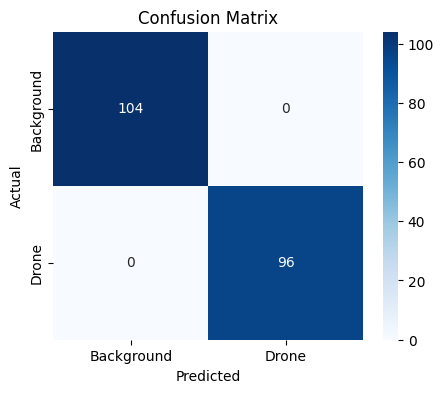

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🎯 Predict
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# 📝 Classification Report
print(classification_report(y_true_labels, y_pred_labels))

# 📊 Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Background', 'Drone'],
            yticklabels=['Background', 'Drone'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def visualize_audio(file_path, label):
    y, sr = librosa.load(file_path, sr=16000)

    plt.figure(figsize=(16, 10))

    # Waveform
    plt.subplot(2, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {label}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

    # Spectrogram
    plt.subplot(2, 2, 2)
    spec = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log', cmap='magma')
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spectrogram (dB) - {label}")

    # MFCC
    plt.subplot(2, 2, 3)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    librosa.display.specshow(mfcc, x_axis='time', sr=sr, cmap='viridis')
    plt.colorbar()
    plt.title(f"MFCCs - {label}")

    # Chroma
    plt.subplot(2, 2, 4)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', sr=sr, cmap='coolwarm')
    plt.colorbar()
    plt.title(f"Chroma - {label}")

    plt.tight_layout()
    plt.show()

<ipython-input-19-5d85ef086afe>:39: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128641 (\N{HELICOPTER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


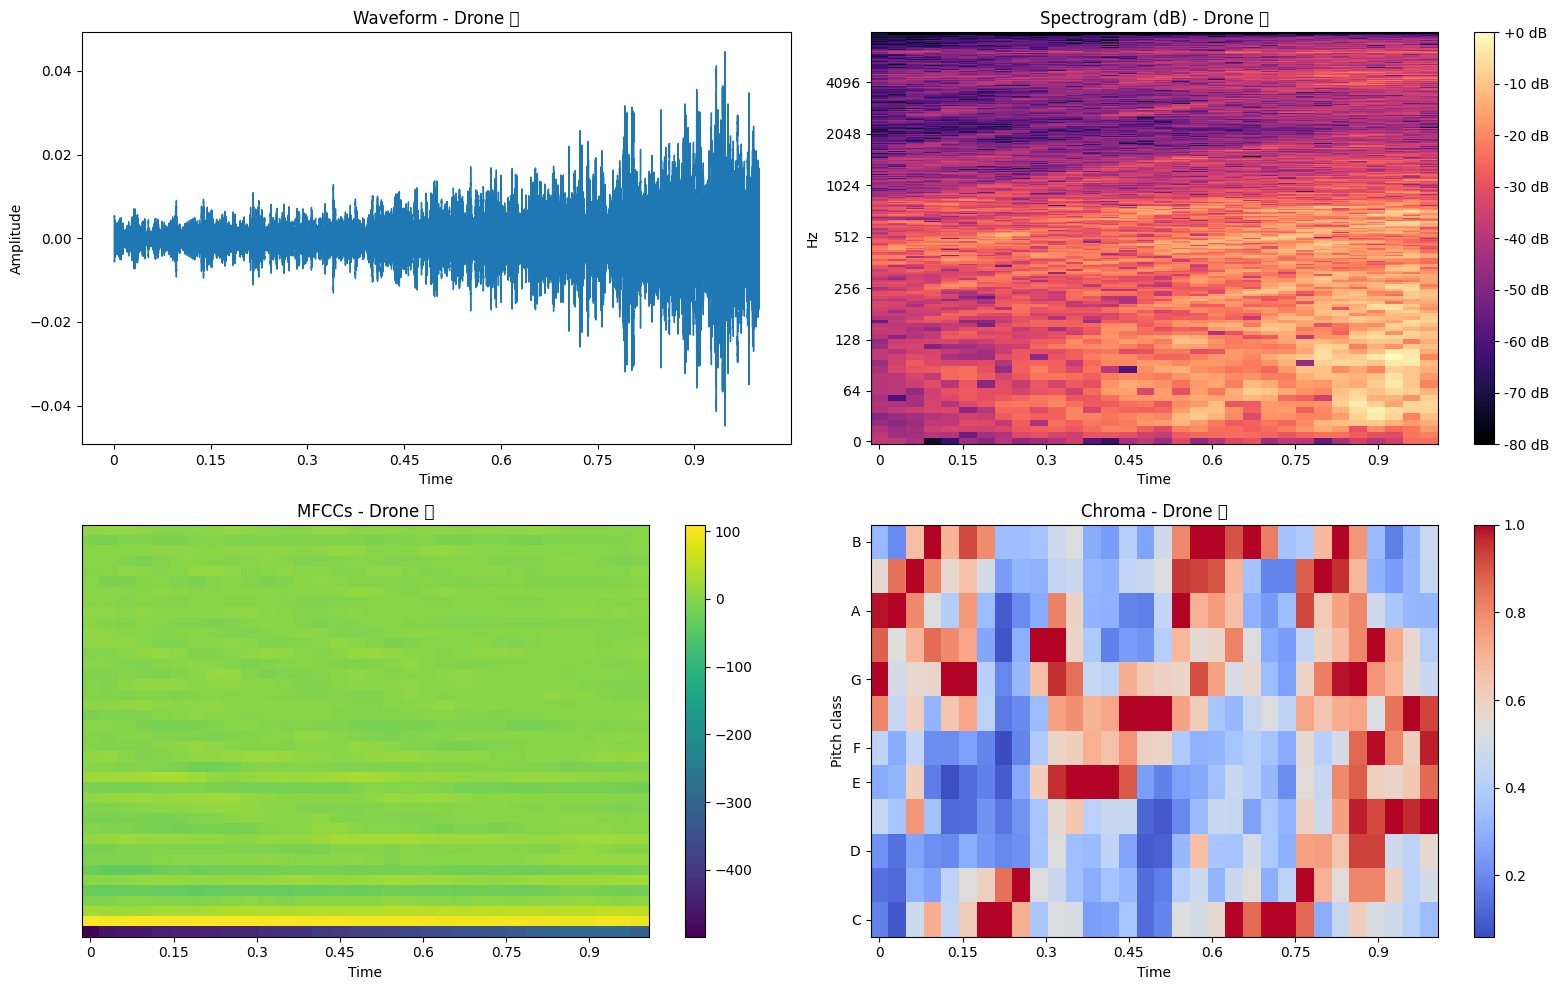

<ipython-input-19-5d85ef086afe>:39: UserWarning: Glyph 128266 (\N{SPEAKER WITH THREE SOUND WAVES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128266 (\N{SPEAKER WITH THREE SOUND WAVES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


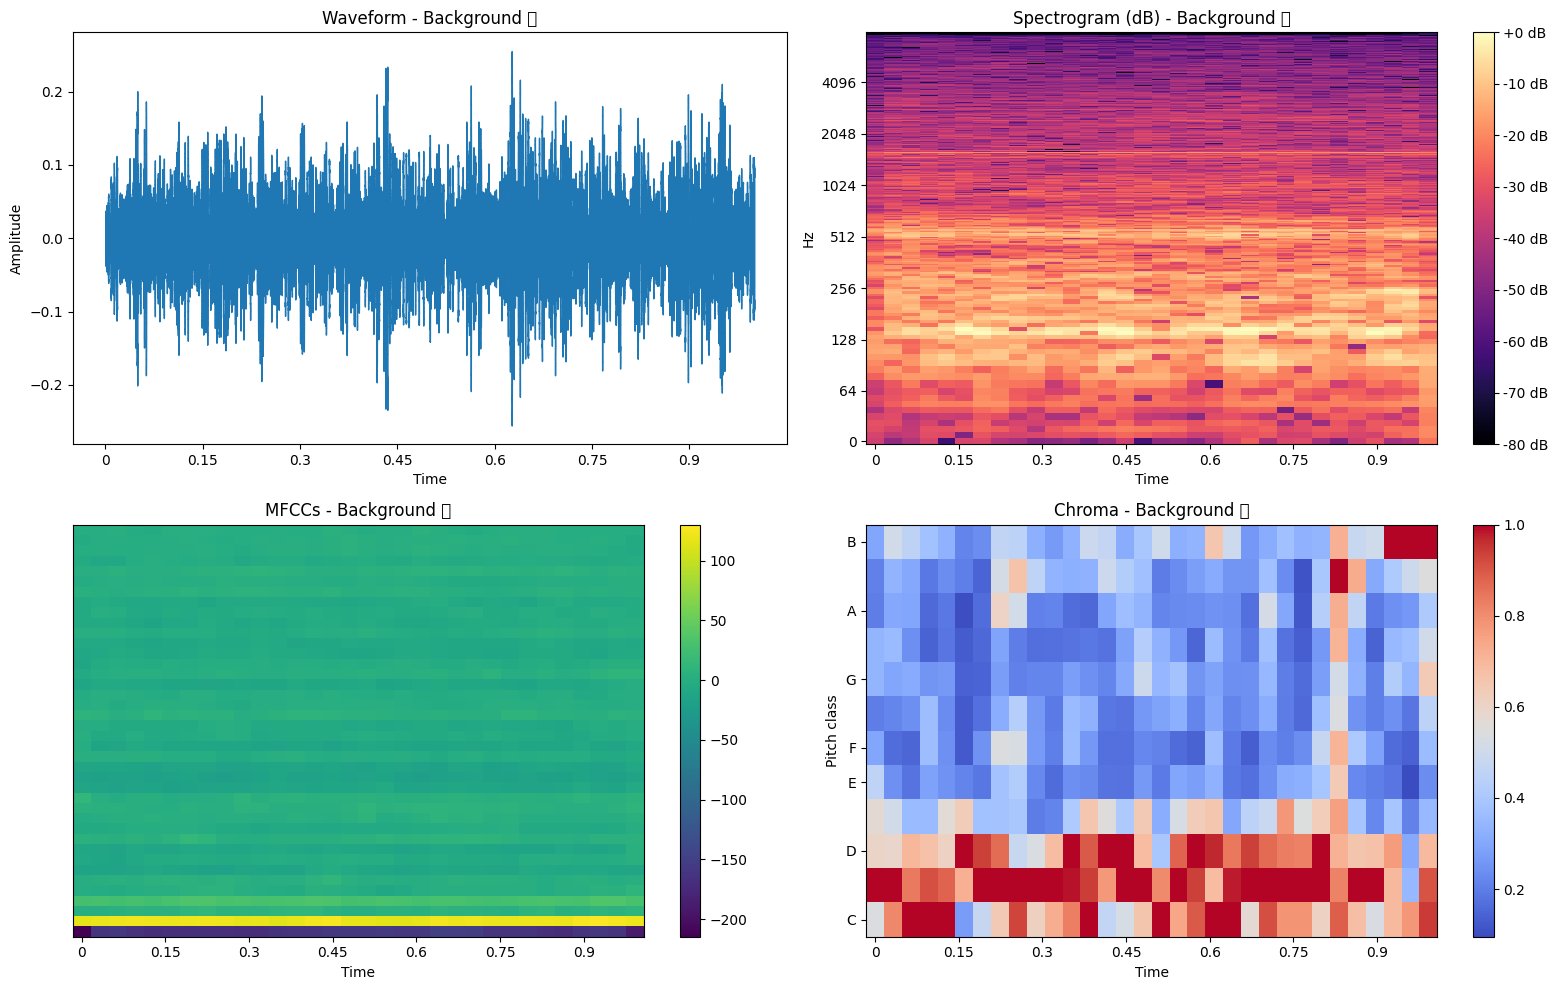

In [ ]:
# Replace with your actual file paths
drone_example = "/content/drive/MyDrive/DRDO PROJECT/Dataset/Drone/drone_1.wav"
bg_example = "/content/drive/MyDrive/DRDO PROJECT/Dataset/Background Noise/Background_Noise1.wav"

visualize_audio(drone_example, label="Drone 🚁")
visualize_audio(bg_example, label="Background 🔊")

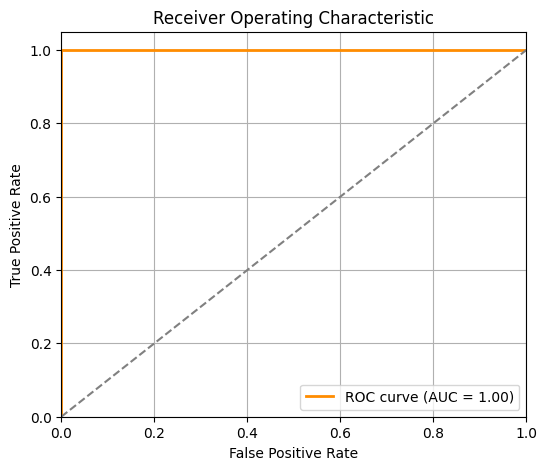

In [ ]:
import numpy as np

# Convert one-hot to class labels
y_test_flat = np.argmax(y_test, axis=1)
y_pred_scores = y_pred[:, 1]  # Probability of class 1 (drone)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test_flat, y_pred_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
import time
start = time.time()
model.predict(np.expand_dims(X_test[0], axis=0))
end = time.time()
print("Inference time (1 sample):", round(end - start, 4), "seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Inference time (1 sample): 0.2205 seconds


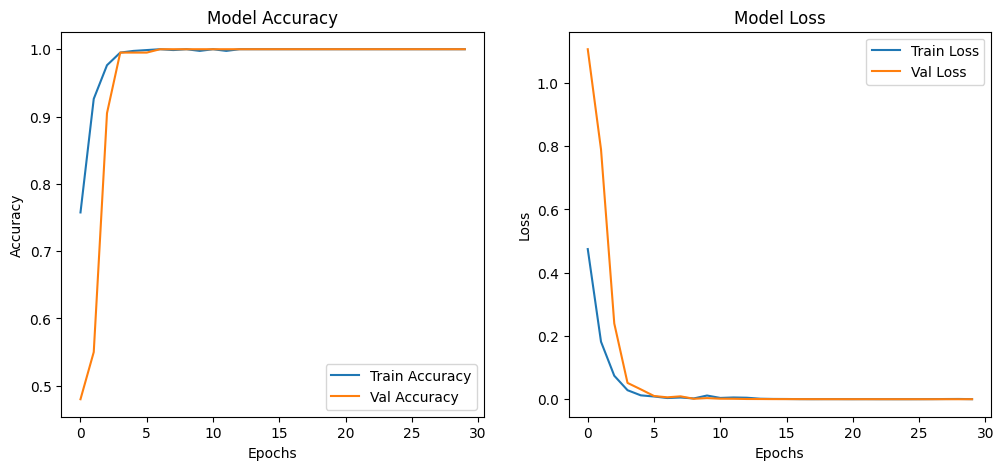

In [ ]:
# Plot Accuracy & Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()